# Evaluation Notebook for Wikitext to Image
Student project summer term 2019, Frank Gabel, Felix Feldmann

### Import necessary dependencies

In [24]:
import torch as th
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [25]:
from networks.TextEncoder import Encoder
from networks.ConditionAugmentation import ConditionAugmentor
from networks.PRO_GAN import ConditionalProGAN
from networks.TextEncoder import PretrainedEncoder

In [26]:
# Select cuda device if possible
device = th.device("cuda" if th.cuda.is_available() else "cpu")

### Initialize Encoder, Network and Conditional Augmentor with pretrained models

In [27]:
# If you do need the pretrained infersent and glove models, please execute this cell
!wget https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip && unzip glove.840B.300d.zip && rm glove.840B.300d.zip

--2019-08-01 15:53:43--  https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154010676 (147M) [application/octet-stream]
Saving to: ‘infersent2.pkl’

infersent2.pkl      100%[===================>] 146,88M  12,2MB/s    in 13s     

2019-08-01 15:53:57 (11,1 MB/s) - ‘infersent2.pkl’ saved [154010676/154010676]

--2019-08-01 15:53:57--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-08-01 15:53:58--  https://nlp.stanford.edu/data/glove.840B.300d.zip


In [28]:
pretrained_encoder_file="infersent2.pkl"
pretrained_embedding_file="glove.840B.300d.txt"

# Needs ~833MB on GPU device
text_encoder = PretrainedEncoder(
    model_file=pretrained_encoder_file,
    embedding_file=pretrained_embedding_file,
    device=device
)

Vocab size : 300000


In [29]:
ca = ConditionAugmentor(
        input_size=4096,
        latent_size=256,
        use_eql=True,
        device=device
    )
ca.load_state_dict(th.load("./Condition_Augmentor_6.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
c_pro_gan = ConditionalProGAN(
        embedding_size=4096,
        depth=7,
        latent_size=512,
        compressed_latent_size=128,
        learning_rate=0.001,
        beta_1=0,
        beta_2=0.99,
        eps=0.00000001,
        drift=0.001,
        n_critic=1,
        use_eql=True,
        loss="wgan-gp",
        use_ema=False,
        ema_decay=0.999,
        device=device)
# Load 
c_pro_gan.gen.load_state_dict(th.load("./GAN_GEN_6.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
def create_grid(samples, scale_factor, sentence):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :return: None (saves a file)
    """
    from torchvision.utils import make_grid, save_image
    from torch.nn.functional import interpolate

    samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

    # upsample the image
    if scale_factor > 1:
        samples = interpolate(samples,
                              scale_factor=scale_factor)
    #save_image(samples, f"{sentence[0]}.png")
    return make_grid(samples)

In [32]:
def create_images(sentence):
    with th.no_grad():
        current_depth=6
        alpha = 1
        v_fixed_embeddings = text_encoder(sentence)
        v_fixed_embeddings = th.from_numpy(v_fixed_embeddings).to(device)
        v_fixed_c_not_hats, _, _ = ca(v_fixed_embeddings)
        v_fixed_noise = th.randn(len(sentence),
                               c_pro_gan.latent_size - v_fixed_c_not_hats.shape[-1]).to(device)
        v_fixed_gan_input = th.cat((v_fixed_c_not_hats, v_fixed_noise), dim=-1)
        grid = create_grid(c_pro_gan.gen(v_fixed_gan_input,current_depth,alpha),
                            int(np.power(2, c_pro_gan.depth - current_depth - 1)),
                           sentence)
        plt.figure(figsize=(10,10))
        plt.title(f"Images for sentence: {sentence}")
        plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)), interpolation='nearest')
        plt.show()

Please enter a sentence:
he british prime minister europe young


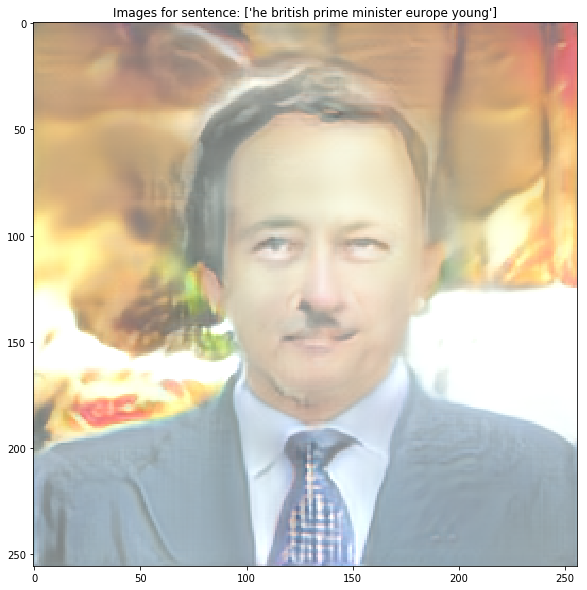

In [34]:
# Run your own sentences or use the examples provided below (taken from validation set)
print("Please enter a sentence:")
sentence = input()
create_images([sentence])

In [35]:
example_woman = ["she Somali politician africa old",
                 "she Chinese communist Party politician asia old",
                 "she Norwegian politician europe young",
                 "she Japanese politician asia middle",
                ]

example_man = ["he 112th Governor of South Carolina canada old",
                 "he Spanish politician europe middle",
                 "he Swiss politician europe middle",
                 "he 54th Governor of New York canada young",
                ]
example_old = ["he Norwegian politician europe old",
                 "he UKIP politician europe old",
                 "he Arkansas politician canada old",
                 "he United States Congressman from Utah canada old",
                ]

example_middle = ["he British politician europe middle",
                 "he British Conservative politician europe middle",
                 "he French politician europe middle",
                 "he Afghanistani politician asia middle",
                ]
example_young = ["he British politician europe young",
                 "he Ukrainian economist europe young",
                 "she Norwegian politician europe young",
                 "he Deputy First Minister of Scotland europe young",
                ]

example_usa = ["he American singer and activist canada young",
                 "he 45th and current president of the United States canada middle",
                 "he American lawyer and politician usa usa canada middle",
                 "she American politician usa canada young",
                ]

example_continent = ["he Latvian politician europe middle",
                 "he Japanese politician asia middle",
                 "he Australian politician australia young",
                 "he Egyptian Prime Minister africa middle",
                ]


In [36]:
example_sentences = ["he politician from Chile brazil old",
                    "she U.S. Supreme Court Justice canada middle",
                    "she United States Senator from Washington canada young",
                    "she United States Senator from Minnesota canada young",
                    "he Italian politician europe old"
                    "she United States Senator from Maine canada middle",
                    "he Austrian politician europe old",
                    "he German Green politician europe middle",
                    "he eleventh President of Austria europe old",
                    "he former Speaker of the United States House of Representatives canada middle",
                    "he former President and Prime Minister of East Timor asia middle"]

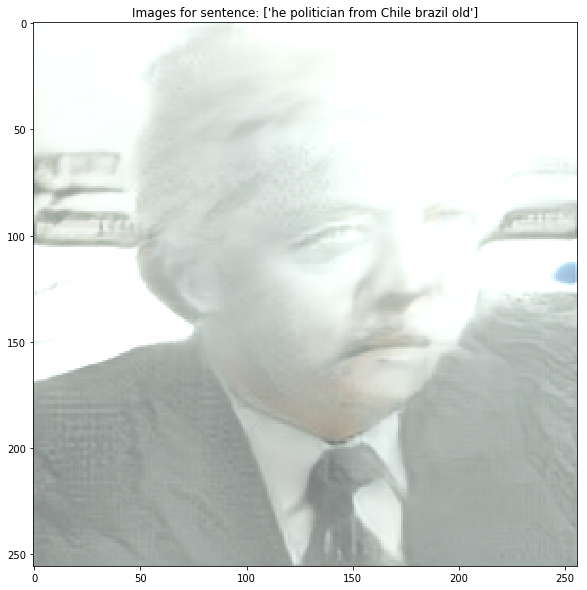

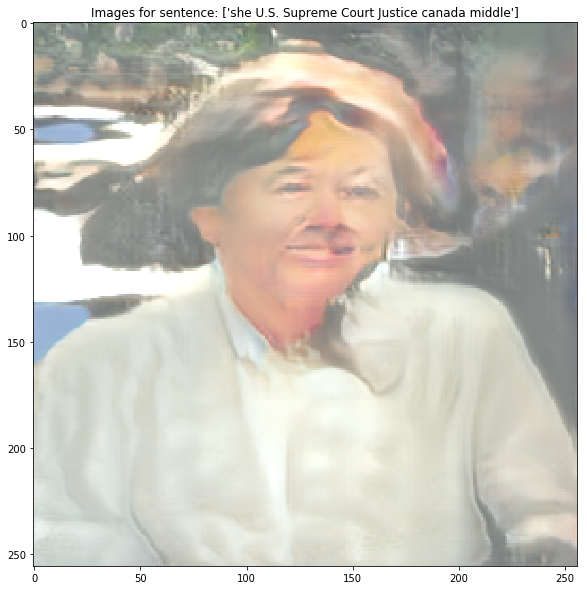

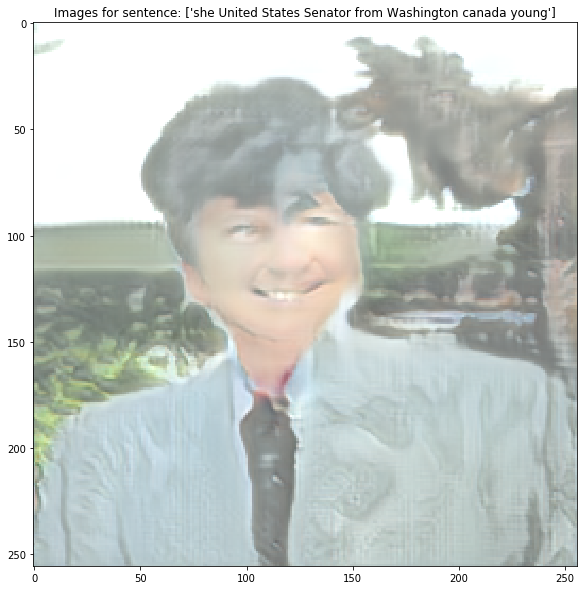

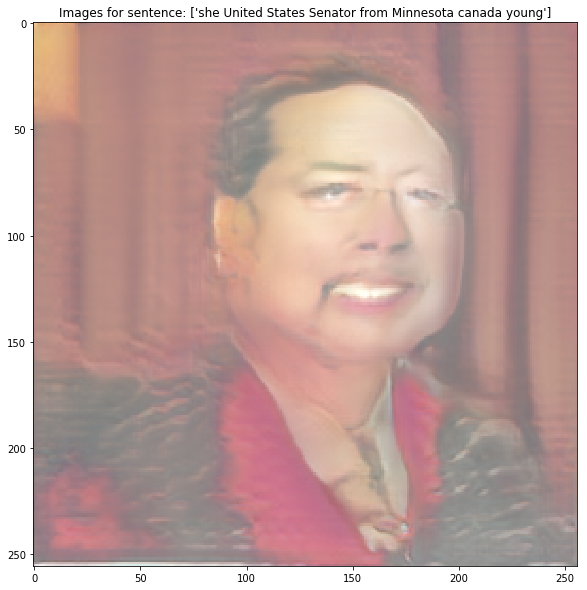

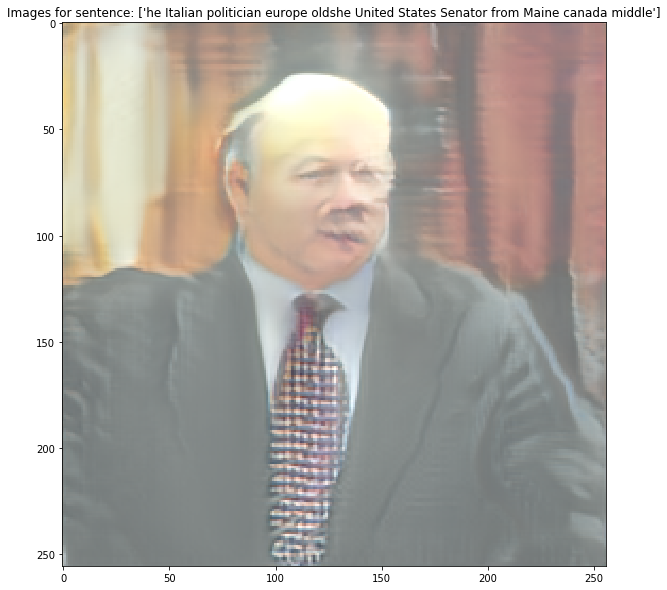

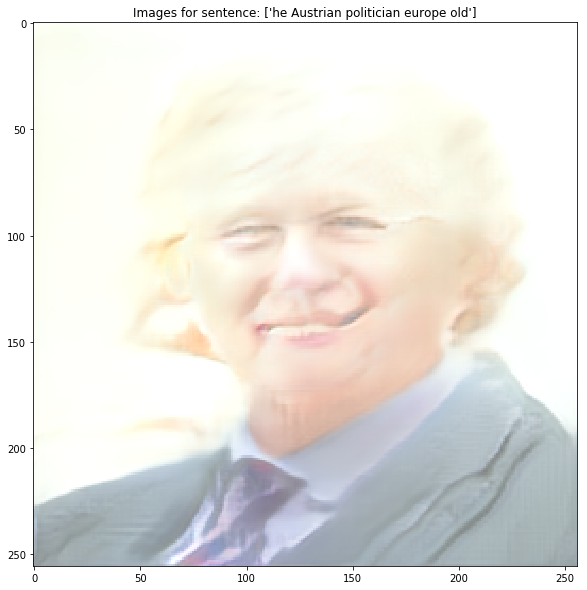

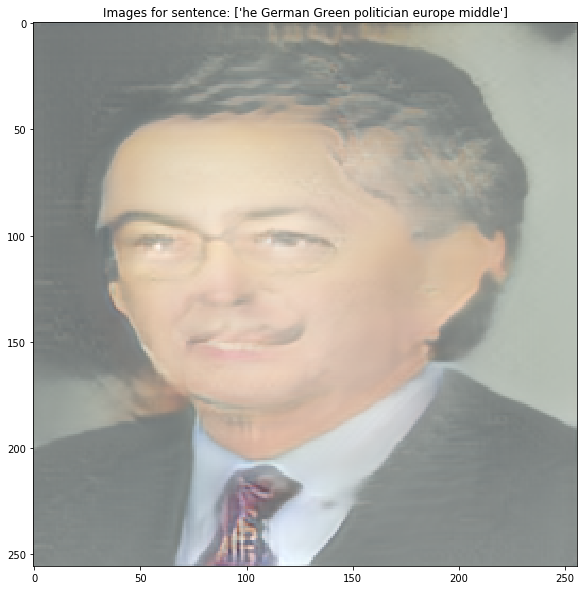

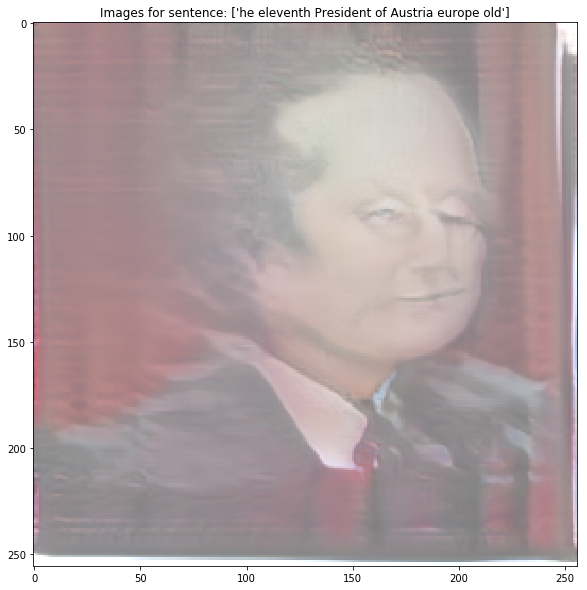

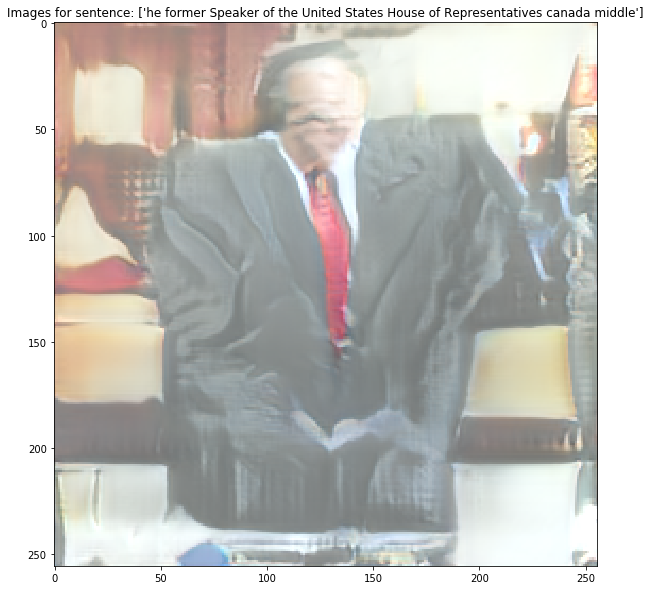

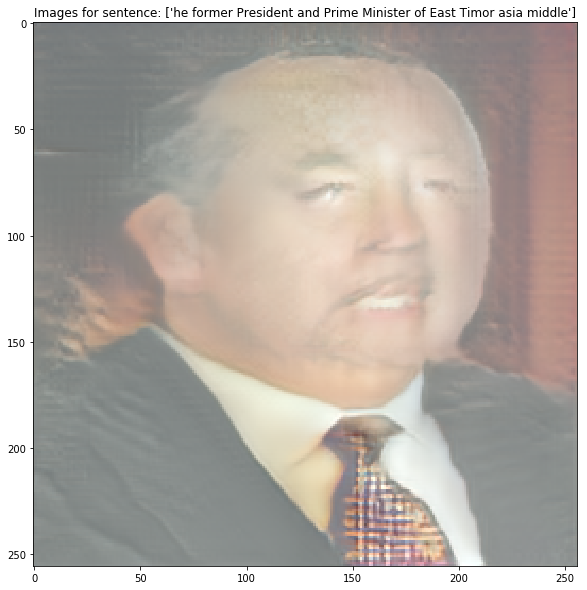

In [38]:
for sentence in example_sentences:
    create_images([sentence])